# 1 The Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Following code is to make test directory have a single folder with both Normal and Tuberculosis datas.
In our case we do not require this part of the code hence its commented.

In [ ]:
# !mv  -v /content/dataset/cnn/tuberculosis/test/Normal/* /content/dataset/cnn/tuberculosis/test/
# !mv  -v /content/dataset/cnn/tuberculosis/test/Tuberculosis/* /content/dataset/cnn/tuberculosis/test/
# !rm -r /content/dataset/cnn/tuberculosis/test/Normal
# !rm -r /content/dataset/cnn/tuberculosis/test/Tuberculosis

# 2 Initialize

## 2.1 Basic Imports

In [3]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

## 2.2 Define Directories

In [4]:
#Define Directories for train, test & Validation Set
train_path = '/content/drive/MyDrive/chest_xray_TB-TEST/train'
test_path = '/content/drive/MyDrive/chest_xray_TB-TEST/test'
valid_path = '/content/drive/MyDrive/chest_xray_TB-TEST/validation'

## 2.3 Basic Parameters

In [5]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

# 3 Preparing the Data

## 3.1 Data Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [7]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 1606 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Found 290 images belonging to 2 classes.


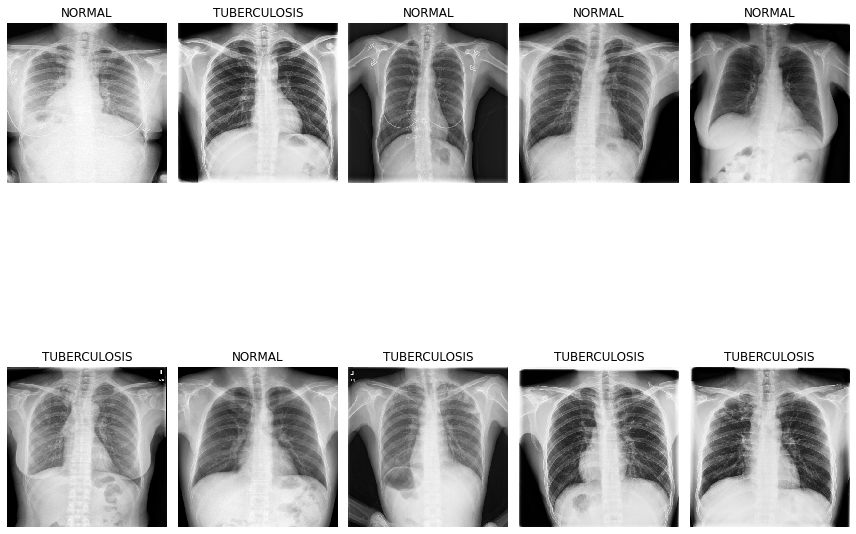

In [8]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# 4 Convolutional Neural Network

## 4.1 Necessary Imports

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 4.2 CNN Architecture

In [10]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

Model Compile

In [11]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model Summary

In [12]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

Visualize CNN model

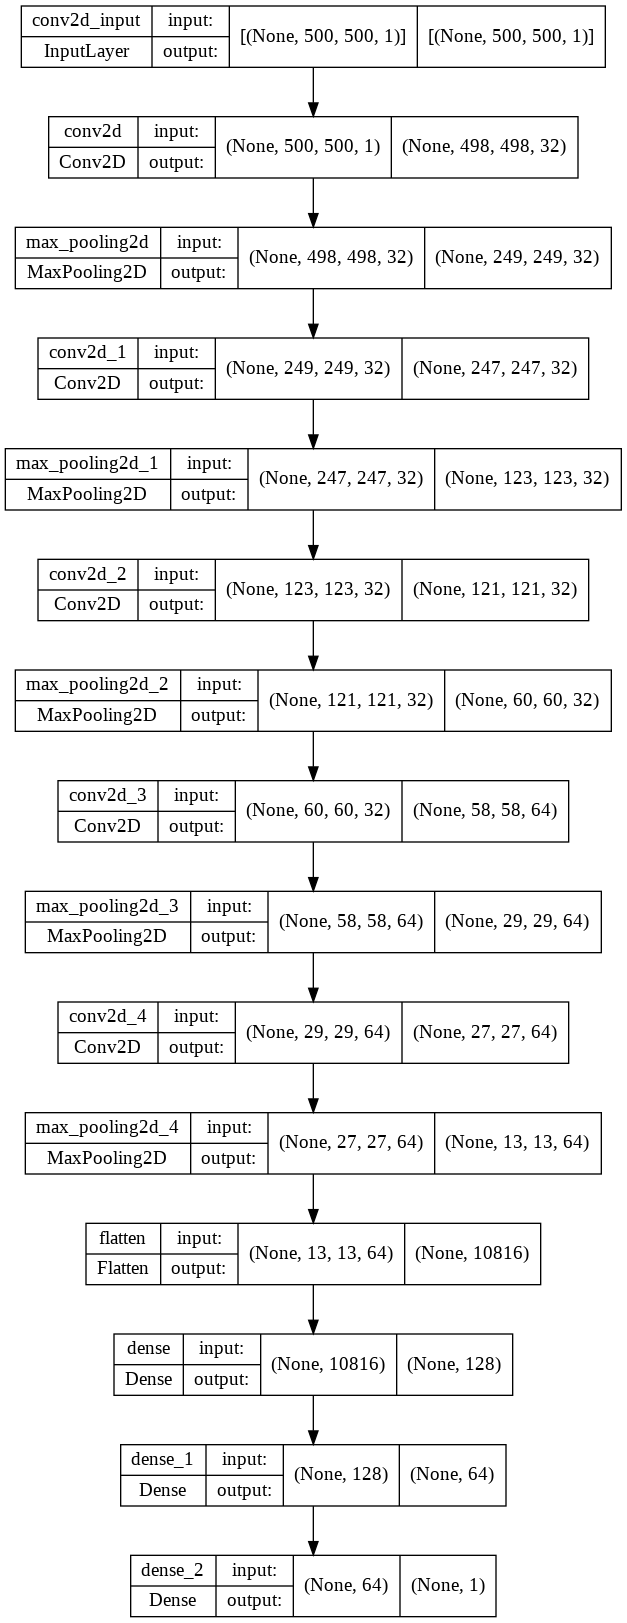

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 4.3 Fit the model

Defining callback list

In [14]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

Assigning Class Weights

In [15]:
from sklearn.utils.class_weight import compute_class_weight
train_classes = train_generator.classes
class_weights = compute_class_weight('balanced', np.unique(train.classes), train.classes),class_weight
#cw = dict(zip( np.unique(train.classes), weights))
#print(cw)

NameError: ignored

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.ravel(y_train,order='C')),
                                                 np.ravel(y_train,order='C'))

NameError: ignored

Training

In [17]:
cnn.fit(train,epochs=25, validation_data=valid,  callbacks=callbacks_list)

Epoch 1/25
101/101 [==============================] - 200s 2s/step - loss: 0.6807 - accuracy: 0.6015 - val_loss: 0.6387 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 2/25
101/101 [==============================] - 21s 208ms/step - loss: 0.6698 - accuracy: 0.6090 - val_loss: 0.5709 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 3/25
101/101 [==============================] - 21s 209ms/step - loss: 0.6107 - accuracy: 0.6600 - val_loss: 0.5635 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/25
101/101 [==============================] - 23s 227ms/step - loss: 0.5756 - accuracy: 0.6955 - val_loss: 0.5497 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 5/25
101/101 [==============================] - 22s 221ms/step - loss: 0.5151 - accuracy: 0.7590 - val_loss: 0.4976 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 6/25
101/101 [==============================] - 21s 207ms/step - loss: 0.4753 - accuracy: 0.7790 - val_loss: 0.4897 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 7/25
101/101 [==============================] - 

# 5 Evaluate

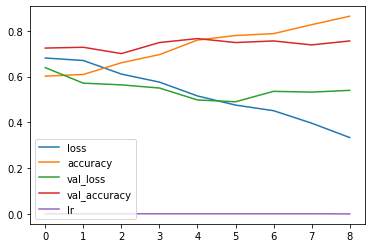

In [18]:
pd.DataFrame(cnn.history.history).plot()

In [19]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

18/18 [==============================] - 55s 3s/step - loss: 0.4840 - accuracy: 0.7944
The testing accuracy is : 79.44250702857971 %


In [20]:
preds = cnn.predict(test,verbose=1)

18/18 [==============================] - 3s 166ms/step


In [21]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Confussion Matrix

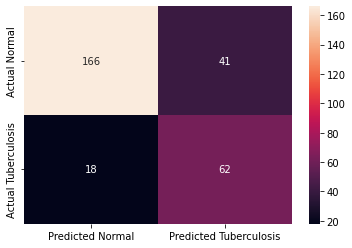

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

Classification Report

In [23]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.90      0.80      0.85       207
TUBERCULOSIS       0.60      0.78      0.68        80

    accuracy                           0.79       287
   macro avg       0.75      0.79      0.76       287
weighted avg       0.82      0.79      0.80       287



(287, 500, 500, 1)
(287,)


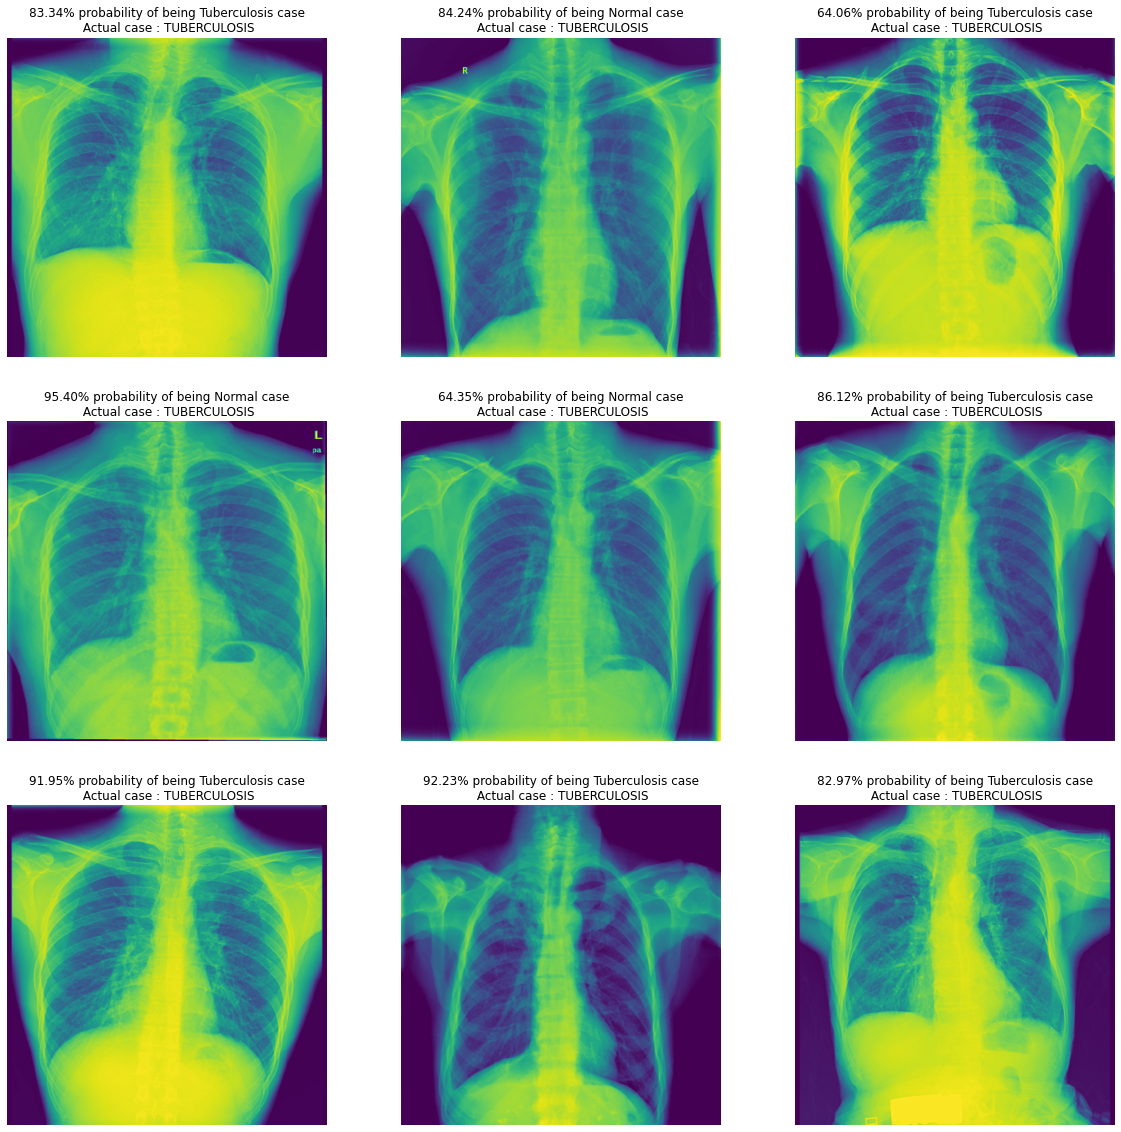

In [24]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
    out = ('{:.2%} probability of being Tuberculosis case'.format(preds[i][0]))
      
      
  else: 
    out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()
